In [1]:
%load_ext autoreload
%autoreload
import tensorflow as tf
import numpy as np
import surreal_single, config
import functools, operator, copy
import tensorflow.contrib.slim as slim
from nets import resnet_v2
from nets.mobilenet import mobilenet_v2
from tensor_info2 import INPUT_TENSOR_INFO, OUTPUT_TENSOR_INFO
tf.reset_default_graph()

/Users/minsubsim/.virtualenvs/cv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [31]:
types = tuple(t['type'] for t in INPUT_TENSOR_INFO)
config.BATCH_SIZE = 10
input_tensors = tf.data.Dataset.from_generator(surreal_single.load, types) \
                               .batch(config.BATCH_SIZE) \
                               .prefetch(config.PREFETCH_SIZE) \
                               .make_one_shot_iterator() \
                               .get_next()
tensors = {}
for tensor, info in zip(input_tensors, INPUT_TENSOR_INFO):
    tensor.set_shape(info['shape'])
    tensors[info['name']] = tensor
print(tensors)

{'image': <tf.Tensor 'IteratorGetNext:0' shape=(10, 401, 401, 3) dtype=float32>, 'hm': <tf.Tensor 'IteratorGetNext:1' shape=(10, 401, 401, 16) dtype=float32>, 'so_x': <tf.Tensor 'IteratorGetNext:2' shape=(10, 401, 401, 16) dtype=float32>, 'so_y': <tf.Tensor 'IteratorGetNext:3' shape=(10, 401, 401, 16) dtype=float32>, 'mo_x': <tf.Tensor 'IteratorGetNext:4' shape=(10, 401, 401, 30) dtype=float32>, 'mo_y': <tf.Tensor 'IteratorGetNext:5' shape=(10, 401, 401, 30) dtype=float32>}


In [32]:
config.STRIDE = 8

MD_H = int((config.TAR_H-1)//config.STRIDE)+1
MD_W = int((config.TAR_W-1)//config.STRIDE)+1

DEPTH = [ti['shape'][-1] for ti in OUTPUT_TENSOR_INFO]
RESULT_SHAPE = (config.BATCH_SIZE, MD_H, MD_W, sum(DEPTH))
RESULT_SIZE = functools.reduce(operator.mul, RESULT_SHAPE[1:])
OUTPUT_SHAPE = (config.BATCH_SIZE, config.TAR_H, config.TAR_W, sum(DEPTH))
OUTPUT_SIZE = functools.reduce(operator.mul, OUTPUT_SHAPE[1:])


In [33]:
def bilinear(indices):
    oy = tf.clip_by_value(indices[1], 0, MD_H-1-1e-8)
    ox = tf.clip_by_value(indices[2], 0, MD_W-1-1e-8)
    iy = [tf.floor(oy), tf.ceil(oy + 1e-9)]
    ix = [tf.floor(ox), tf.ceil(ox + 1e-9)]
    idx_p = []
    for y in iy:
        for x in ix:
            indices[1] = y
            indices[2] = x
            idx = tf.cast(tf.stack(indices, axis=-1), tf.int32)
            p = (1 - tf.abs(y - oy)) * (1 - tf.abs(x - ox))
            idx_p.append((idx, p))
    return idx_p

def gather_bilinear(params, indices):
    idx_p = bilinear(indices)
    res = []
    for idx, p in idx_p:
        r = tf.gather_nd(params, idx)
        res.append(r * p)
    return tf.add_n(res)

def scatter_bilinear(params, indices, shape):
    idx_p = bilinear(indices)
    res = []
    for idx, p in idx_p:
        r = tf.scatter_nd(idx, params, shape)
        if len(r.shape) > len(p.shape):
            p = tf.expand_dims(p, axis=-1)
        res.append(r * p)
    return tf.add_n(res)

In [34]:
def resize(tensor):
    return tf.image.resize_images(
        tensor,
        (config.TAR_H, config.TAR_W),
        method=tf.image.ResizeMethod.BILINEAR,
        align_corners=True)

with slim.arg_scope(mobilenet_v2.training_scope(is_training=True)):
    model_output, _ = mobilenet_v2.mobilenet_base(tensors['image'], output_stride=config.STRIDE)
    print('model_output', model_output)
    hm_pred = slim.conv2d(model_output, config.NUM_KP, [1, 1], activation_fn=tf.sigmoid)
    so_x_pred = slim.conv2d(model_output, config.NUM_KP, [1, 1], activation_fn=None)
    so_y_pred = slim.conv2d(model_output, config.NUM_KP, [1, 1], activation_fn=None)
    mo_x_pred = slim.conv2d(model_output, config.NUM_EDGE, [1, 1], activation_fn=None)
    mo_y_pred = slim.conv2d(model_output, config.NUM_EDGE, [1, 1], activation_fn=None)

    print(hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred)
    b, y, x, _ = np.mgrid[:config.BATCH_SIZE, :MD_H, :MD_W, :config.NUM_EDGE]
    print(config.EDGES[:, 0])
    i = np.tile(config.EDGES[:, 0], [config.BATCH_SIZE, MD_H, MD_W, 1])
    for _ in range(config.NUM_RECURRENT):
        mo_p = [b, y+mo_y_pred, x+mo_x_pred, i]
        mo_x_pred = gather_bilinear(so_x_pred, mo_p) + mo_x_pred
        mo_y_pred = gather_bilinear(so_y_pred, mo_p) + mo_y_pred
    print(hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred)
    hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred = [resize(x) for x in [hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred]]
    print(hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred)
    so_x_pred, so_y_pred, mo_x_pred, mo_y_pred = [x * config.STRIDE for x in [so_x_pred, so_y_pred, mo_x_pred, mo_y_pred]]
    print(hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred)

model_output Tensor("MobilenetV2/Conv_1/Relu6:0", shape=(10, 51, 51, 1280), dtype=float32)
Tensor("Conv/Sigmoid:0", shape=(10, 51, 51, 16), dtype=float32) Tensor("Conv_1/BatchNorm/FusedBatchNorm:0", shape=(10, 51, 51, 16), dtype=float32) Tensor("Conv_2/BatchNorm/FusedBatchNorm:0", shape=(10, 51, 51, 16), dtype=float32) Tensor("Conv_3/BatchNorm/FusedBatchNorm:0", shape=(10, 51, 51, 30), dtype=float32) Tensor("Conv_4/BatchNorm/FusedBatchNorm:0", shape=(10, 51, 51, 30), dtype=float32)
[ 0  1  2  3  4  2  6  7  2  9 10 11  9 13 14  1  2  3  4  5  6  7  8  9
 10 11 12 13 14 15]
Tensor("Conv/Sigmoid:0", shape=(10, 51, 51, 16), dtype=float32) Tensor("Conv_1/BatchNorm/FusedBatchNorm:0", shape=(10, 51, 51, 16), dtype=float32) Tensor("Conv_2/BatchNorm/FusedBatchNorm:0", shape=(10, 51, 51, 16), dtype=float32) Tensor("add_12:0", shape=(10, 51, 51, 30), dtype=float32) Tensor("add_15:0", shape=(10, 51, 51, 30), dtype=float32)
Tensor("resize_images/ResizeBilinear:0", shape=(10, 401, 401, 16), dtype=f

In [15]:
hm_loss = - tf.reduce_mean(tensors['hm'] * tf.log(hm_pred + 1e-9) + (1 - tensors['hm']) * tf.log(1 - hm_pred + 1e-9))
so_loss = tf.abs(tensors['so_x'] - so_x_pred) / config.RADIUS + tf.abs(tensors['so_y'] - so_y_pred) / config.RADIUS
mo_loss = tf.abs(tensors['mo_x'] - mo_x_pred) / config.RADIUS + tf.abs(tensors['mo_y'] - mo_y_pred) / config.RADIUS

disc_only = tf.cast(tensors['hm'], tf.float32)
disc_size = tf.reduce_sum(disc_only, axis=[1, 2]) + 1e-9
so_loss = tf.reduce_mean(tf.reduce_sum(so_loss * disc_only, axis=[1, 2]) / disc_size)

disc_only = tf.cast(tf.gather(tensors['hm'], config.EDGES[:, 0], axis=-1), tf.float32)
disc_size = tf.reduce_sum(disc_only, axis=[1, 2]) + 1e-9
mo_loss = tf.reduce_mean(tf.reduce_sum(mo_loss * disc_only, axis=[1, 2]) / disc_size)

In [16]:
total_loss = hm_loss * 4.0 + so_loss * 1.0 + mo_loss * 0.5

In [17]:
tf.summary.scalar('losses/hm_loss', hm_loss)
tf.summary.scalar('losses/so_loss', so_loss)
tf.summary.scalar('losses/mo_loss', mo_loss)
tf.summary.scalar('losses/total_loss', total_loss)

<tf.Tensor 'losses/total_loss:0' shape=() dtype=string>

In [18]:
tf.summary.histogram("pred_dist/resnet", model_output)
tf.summary.histogram("pred_dist/heatmap", hm_pred)
tf.summary.histogram("pred_dist/short_off_x", so_x_pred)
tf.summary.histogram("pred_dist/short_off_y", so_y_pred)
tf.summary.histogram("pred_dist/mid_off_x", mo_x_pred)
tf.summary.histogram("pred_dist/mid_off_y", mo_y_pred)

tf.summary.histogram("true_dist/heatmap", tensors['hm'])
tf.summary.histogram("true_dist/short_off_x", tensors['so_x'])
tf.summary.histogram("true_dist/short_off_y", tensors['so_y'])
tf.summary.histogram("true_dist/mid_off_x", tensors['mo_x'])
tf.summary.histogram("true_dist/mid_off_y", tensors['mo_y'])

optimizer = tf.train.AdamOptimizer()
train_op = slim.learning.create_train_op(total_loss, optimizer)

checkpoint_path = 'mbnet/mobilenet_v2_1.0_224.ckpt'
variables = slim.get_model_variables()
restore_map = {}
for v in variables:
    if not v.name.startswith('resnet'):
        continue
    org_name = v.name.split(':')[0]
    restore_map[org_name] = v
    print(org_name, ':', v.name)
init_assign_op, init_feed_dict = slim.assign_from_checkpoint(checkpoint_path, restore_map)

In [19]:
import time, os, shutil
#log_dir = 'logs/log_' + str(time.time())[-5:]
log_dir = 'logs/mb_log_test2'
#shutil.rmtree(log_dir)
os.mkdir(log_dir)

In [20]:
def InitAssignFn(sess):
    sess.run(init_assign_op, init_feed_dict)
    
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=True)):
    tf.contrib.slim.learning.train(train_op,
                                   '/home/ubuntu/personlab/'+log_dir,
                                   init_fn=InitAssignFn,
                                   log_every_n_steps=100,
                                   save_summaries_secs=30,
                                  )

Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/mb_log_test2/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 0.
INFO:tensorflow:global_step/sec: 0.223419
INFO:tensorflow:Recording summary at step 7.
INFO:tensorflow:global_step/sec: 0.413762
INFO:tensorflow:Recording summary at step 20.
INFO:tensorflow:global_step/sec: 0.41146
INFO:tensorflow:Recording summary at step 31.
INFO:tensorflow:global_step/sec: 0.412935
INFO:tensorflow:Recording summary at step 44.
INFO:tensorflow:global_step/sec: 0.43935
INFO:tensorflow:Recording summary at step 57.


KeyboardInterrupt: 

In [ ]:
from tensorflow.python.tools import inspect_checkpoint
inspect_checkpoint.print_tensors_in_checkpoint_file(checkpoint_path, tensor_name='', all_tensors=False, all_tensor_names=True)

In [211]:
import time
from tqdm import tqdm
saver = tf.train.Saver()
with tf.Session() as sess:
    checkpoint_path = 'model/mobilenet-400-16/model.ckpt-33019'
    saver.restore(sess, checkpoint_path)
    res = []
    start = time.time()
    get_size = 10
    for i in tqdm(range(get_size)):
        res.append(sess.run([model_output, tensors['image'], tensors['mo_x'], tensors['mo_y'], 
                             hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred]))
    print('take:', (time.time() - start)/get_size)


INFO:tensorflow:Restoring parameters from model/mobilenet-400-16/model.ckpt-33019


100%|██████████| 10/10 [04:47<00:00, 28.78s/it]

take: 28.778632760047913


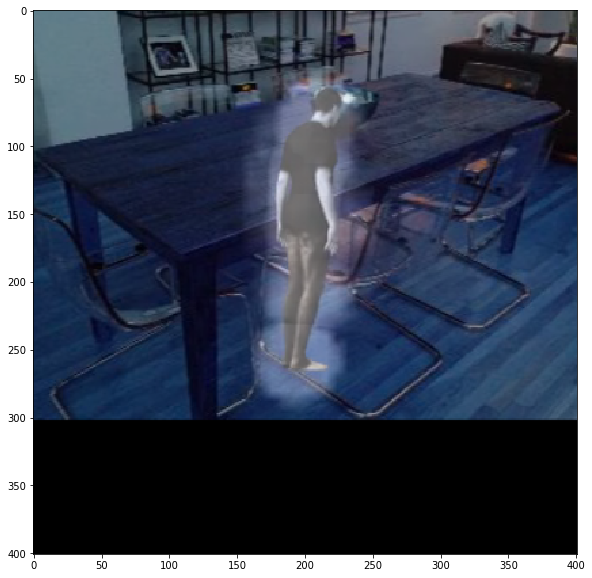

In [215]:
import cv2
from matplotlib import pyplot as plt

mdout, img, mot_x, mot_y, \
hm, s_off_x, s_off_y, m_off_x, m_off_y = res[9]

def overlay(img, over, alpha=0.5):
    out = img.copy()
    if img.max() > 1.:
        out = out / 255.
    out *= 1-alpha
    if len(over.shape)==2:
        out += alpha*over[:,:,np.newaxis]
    else:
        out += alpha*over    
    return out
b_i = 9
plt.figure()
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(overlay(img[b_i, ...], np.max(hm[b_i, ...], axis=-1), alpha=0.4))

In [216]:
def bilinear(indices):
    oy = np.clip(indices[1], 0, config.TAR_H-1)
    ox = np.clip(indices[2], 0, config.TAR_W-1)
    iy = [np.floor(oy), np.clip(np.ceil(oy + 1e-9), 0, config.TAR_H-1)]
    ix = [np.floor(ox), np.clip(np.ceil(ox + 1e-9), 0, config.TAR_W-1)]
    idx_p = []
    for y in iy:
        for x in ix:
            indices[1] = y
            indices[2] = x
            idx = np.stack(indices, axis=-1).astype(np.int32)
            p = (1 - np.abs(y - oy)) * (1 - np.abs(x - ox))
            idx_p.append((idx, p))
    return idx_p

def gather_bilinear(params, indices):
    idx_p = bilinear(indices)
    res = []
    for idx, p in idx_p:
        r = tf.gather_nd(params, idx)
        res.append(r * p)
    return tf.add_n(res)

def scatter_bilinear(params, indices):
    idx_p = bilinear(indices)
    res = []
    for idx, p in idx_p:
        print()
        #res.append(params[idx] * p)
    return res

In [217]:

b, y, x, i = np.mgrid[:config.BATCH_SIZE, :config.TAR_H, :config.TAR_W, :config.NUM_KP]
y = y + s_off_y
x = x + s_off_x
idx_p = bilinear([b, y, x, i])

In [218]:
print(idx_p[0][0])

[[[[[  0  15   0   0]
    [  0  17   0   1]
    [  0   0   0   2]
    ...
    [  0   0   0  13]
    [  0   0   0  14]
    [  0  23   0  15]]

   [[  0  15   0   0]
    [  0  17   0   1]
    [  0   0   0   2]
    ...
    [  0   0   0  13]
    [  0   0   0  14]
    [  0  23   0  15]]

   [[  0  15   0   0]
    [  0  17   0   1]
    [  0   0   0   2]
    ...
    [  0   0   0  13]
    [  0   0   0  14]
    [  0  23   0  15]]

   ...

   [[  0  10 400   0]
    [  0  11 400   1]
    [  0   0 399   2]
    ...
    [  0   0 393  13]
    [  0   0 392  14]
    [  0  18 388  15]]

   [[  0   9 400   0]
    [  0  10 400   1]
    [  0   0 400   2]
    ...
    [  0   0 395  13]
    [  0   0 393  14]
    [  0  17 390  15]]

   [[  0   9 400   0]
    [  0  10 400   1]
    [  0   0 400   2]
    ...
    [  0   0 396  13]
    [  0   0 395  14]
    [  0  16 391  15]]]


  [[[  0  14   0   0]
    [  0  16   0   1]
    [  0   0   0   2]
    ...
    [  0   0   0  13]
    [  0   0   0  14]
    [  0  21   0  15

In [219]:
hm2 = np.zeros(hm.shape)
for idx, p in idx_p:
    print(idx.shape)
    i = [idx[...,0], idx[...,1], idx[...,2], idx[...,3]]
    np.add.at(hm2, i, hm*p)
hm2 /= np.pi * config.RADIUS ** 2 
np.max(hm2), np.min(hm2)

(10, 401, 401, 16, 4)
(10, 401, 401, 16, 4)
(10, 401, 401, 16, 4)
(10, 401, 401, 16, 4)


(0.17150745680696922, 0.0)

In [220]:
hm2

array([[[[0.00000000e+00, 0.00000000e+00, 2.49368612e-05, ...,
          7.50502188e-05, 7.95953381e-05, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 6.81757432e-06, ...,
          8.25374866e-06, 5.46717344e-06, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 6.80642520e-06, ...,
          8.24576846e-06, 5.46102087e-06, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 5.65554318e-06, ...,
          3.34880585e-06, 8.04404302e-07, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 5.47834316e-06, ...,
          2.25063052e-06, 8.17700265e-08, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 3.16437926e-05, ...,
          2.35448444e-06, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 3.86409073e-06, ...,
          3.99322205e-06, 7.46984522e-06, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 8.39728652e-07, ...,
          6.17177792e-07, 6.93975673e-07, 0.00000000e+00],
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


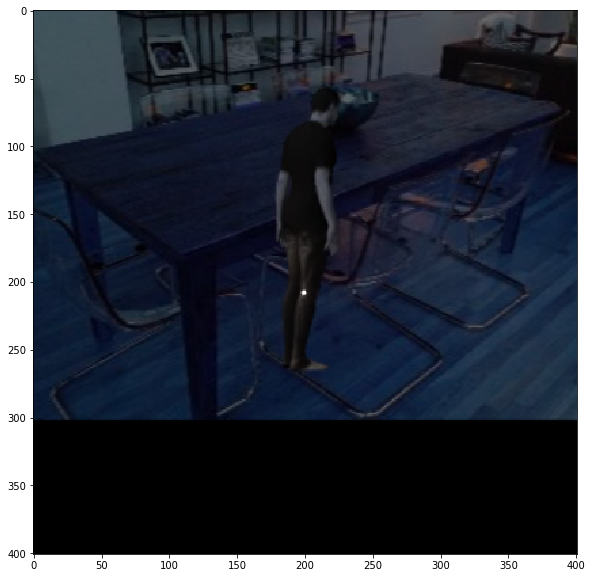

In [221]:
b_i=1
plt.figure()
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(overlay(img[b_i, ...], hm2[b_i, ..., 11]*30, alpha=0.6))

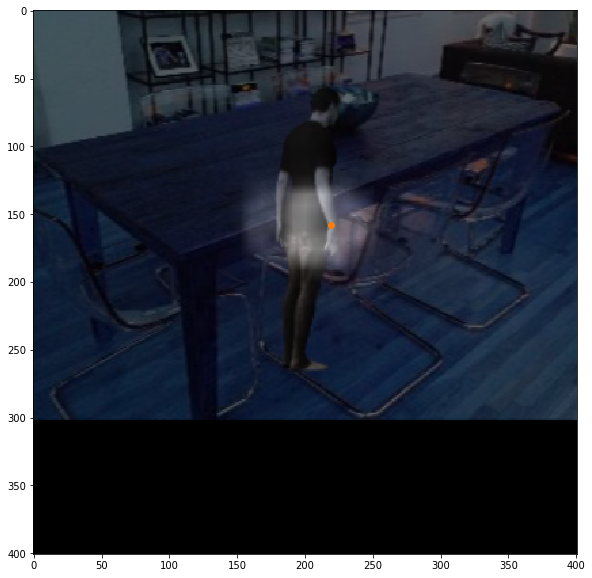

In [232]:
### from skimage.feature import peak_local_max

kp_i = 5
coordinates = peak_local_max(hm2[b_i, ..., kp_i], min_distance=5, threshold_abs=0.01)
lm_y, lm_x = coordinates[0]

end_y = lm_y + mot_y[b_i, lm_y, lm_x, kp_i]
end_x = lm_x + mot_x[b_i, lm_y, lm_x, kp_i]
import matplotlib.pyplot as plt
plt.plot(lm_x, lm_y, end_x, end_y, marker = 'o')
plt.imshow(overlay(img[b_i, ...], hm[b_i, ..., kp_i], alpha=0.6))

In [227]:
mot_y

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [210]:
print(np.max(m_off_x))

109.82164


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-34.0
-34.0
-34.0
-34.0
-34.0
-34.0
-34.0
0.0
0.0
0.0
0.0
0.0
-39.0
-39.0
-39.0
-39.0
-39.0
-39.0
-39.0
-39.0
0.0
0.0
0.0
-44.0
-44.0
-44.0
-44.0
-49.0
20


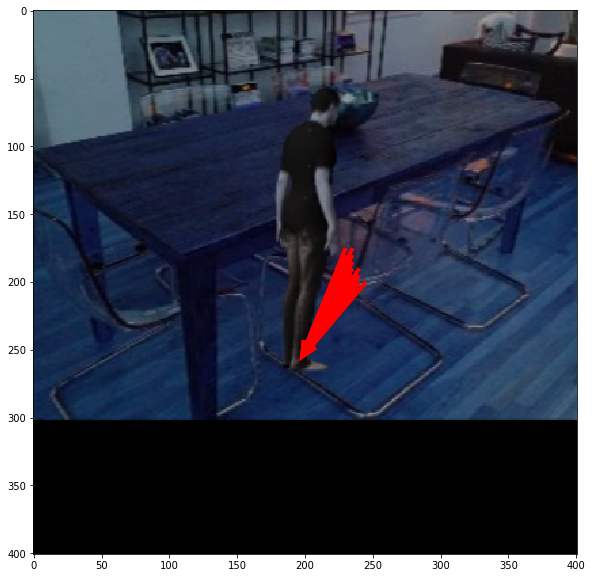

In [261]:
plt.figure()
plt.rcParams['figure.figsize'] = [10, 10]
r = []

for x in range(config.TAR_H):
    if x%5 != 0:
        continue
    for y in range(config.TAR_W):
        if y%5 != 0:
            continue
        i = 11
        #for i in range(config.NUM_KP):
        if hm[b_i][x][y][i] > 0.1:
            print(mot_y[b_i, x, y, i])
            if abs(mot_x[b_i][x][y][i]) + abs(mot_y[b_i][x][y][i]) > 0:
                r.append((y, x, mot_y[b_i][x][y][i], mot_x[b_i][x][y][i]))
            
print(len(r))
X, Y, U, V = zip(*r)
plt.quiver(Y, X, U, V, color='r', angles='xy', scale_units='xy', scale=1)
plt.imshow(overlay(img[b_i, ...], np.max(hm2[b_i, ...], axis=-1), alpha=0.4))

In [258]:
print(mot_x.shape)
np.max(mot_x[..., 11])

(10, 401, 401, 30)


99.0

In [ ]:
config.EDGES[:, ::-1]

In [190]:
y = np.array([[1, 2, 1, 2],
              [2, 2, 0, 0],
              [5, 3, 4, 4]])

(array([0, 0, 0, 2, 2, 2, 2]), array([1, 2, 3, 0, 1, 2, 3]))

In [2]:
rr = []
for res in surreal_single.load():
    rr.append(res)
    if len(rr) >= 10:
        break
img, hm, so_x, so_y, mo_x, mo_y = zip(*rr)
    

128


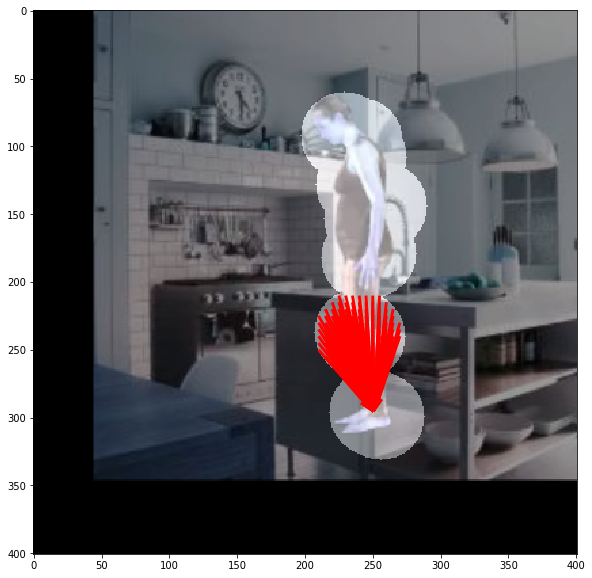

In [9]:
import cv2
from matplotlib import pyplot as plt
def overlay(img, over, alpha=0.5):
    out = img.copy()
    if img.max() > 1.:
        out = out / 255.
    out *= 1-alpha
    if len(over.shape)==2:
        out += alpha*over[:,:,np.newaxis]
    else:
        out += alpha*over    
    return out

plt.figure()
plt.rcParams['figure.figsize'] = [10, 10]
r = []
b_i = 0

for x in range(config.TAR_H):
    if x%5 != 0:
        continue
    for y in range(config.TAR_W):
        if y%5 != 0:
            continue
        i = 11
        #for i in range(config.NUM_KP):
        dx = mo_x[b_i][x][y][i]
        dy = mo_y[b_i][x][y][i]
        if abs(dx) + abs(dy) > 0:
            r.append((x, y, dx, dy))
            
print(len(r))
X, Y, U, V = zip(*r)
plt.quiver(Y, X, U, V, color='r', angles='xy', scale_units='xy', scale=1)
plt.imshow(overlay(img[b_i], np.max(hm[b_i], axis=-1), alpha=0.4))
    